# Week 5: GANs

## Brief Description
### This project uses generative adversarial networks (GAN's) to convert photographic images into the style of Monet's paintings. GAN's work by creating generators and discriminators based on neural networks that take in source images and translate them in an attempt to "trick" the discriminator into accepting them as a "real" image, which leads to only the best generative images and properties being learned and outputted. There are 300 Monet reference paintings and 7038 photos provided in the forms of .jpg images or .tfrec files with dimensions 256 x 256 pixels.  

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image

base_dir = "/kaggle/input/gan-getting-started/"

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

monet_files = tf.io.gfile.glob(str(base_dir + "monet_tfrec/*.tfrec"))
photo_files = tf.io.gfile.glob(str(base_dir + "photo_tfrec/*.tfrec"))

print(f"\nNumber of Monet painting TFREC files: {len(monet_files)}")
print(f"Number of photo TFREC files: {len(photo_files)}\n")

n_monet  = sum(1 for file in os.listdir(base_dir + "monet_jpg") if file.endswith(".jpg"))
n_photo  = sum(1 for file in os.listdir(base_dir + "photo_jpg") if file.endswith(".jpg"))

print(f"\nNumber of Monet painting JPG files: {n_monet}")
print(f"Number of photo JPG files: {n_photo}\n")

m_path = os.listdir(base_dir + "monet_jpg")[0]
p_path = os.listdir(base_dir + "photo_jpg")[0]

with Image.open(base_dir + "monet_jpg/" + m_path) as img:
    print(f"Dimensions of Monet painting JPG's: {img.size}")
    
with Image.open(base_dir + "photo_jpg/" + p_path) as img:
    print(f"Dimensions of photo JPG's: {img.size}")

2024-04-26 19:39:31.211309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:39:31.211418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:39:31.327421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.15.0

Number of Monet painting TFREC files: 5
Number of photo TFREC files: 20


Number of Monet painting JPG files: 300
Number of photo JPG files: 7038

Dimensions of Monet painting JPG's: (256, 256)
Dimensions of photo JPG's: (256, 256)


## Exploratory Data Analysis
### While we may not need to worry about "cleaning" any image data, we do need to translate and load in our data in a way that can be used by the model. I opted to use the .tfrec files over the .jpg files due to the efficiency and speed which we can work with them using tensorflow, but this required some decoding and loading using the tensorflow library. Finally, once the data is processed, we can print out some example 256 x 256 pixel images from either category for comparison.

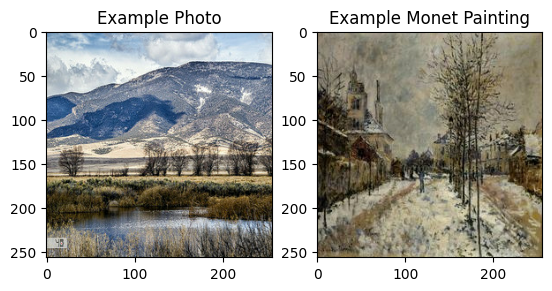

In [2]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(monet_files, labeled=True).batch(1)
photo_ds = load_dataset(photo_files, labeled=True).batch(1)
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title("Example Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Example Monet Painting")
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Model Building and Training
### Building this model on my own was a very daunting task, so I decided to leverage code from Amy Jang's CycleGAN tutorial on Kaggle. A CycleGAN is a special type of GAN that is able to translate images from one form (domain) to another without having to pair our categories of images. Basically, our images are received in under different domains, and our 2 discriminators are used to distinguish between real and translated images. If the image generated by the generator is good enough to "fool" the discriminator, it is used as the model's output. Basically, traits are gathered from the target images and added to the source images until the image is accepted by the discriminator, and we have our outputted image. Before this is possible, we have to write methods for downsampling and upsampling images for the generator and discriminator, as well as create a CycleGAN class to control the training behavior of our model.

In [3]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos
    
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
    
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
    
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

Epoch 1/25


I0000 00:00:1714160527.719555      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 209s 218ms/step - monet_disc_loss: 0.6582 - monet_gen_loss: 5.1581 - photo_disc_loss: 0.6064 - photo_gen_loss: 5.3563 - loss: 0.0000e+00
Epoch 2/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - monet_disc_loss: 0.6458 - monet_gen_loss: 3.6257 - photo_disc_loss: 0.6262 - photo_gen_loss: 3.7336 - loss: 0.0000e+00
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 3.5755 - photo_disc_loss: 0.6208 - photo_gen_loss: 3.6495 - loss: 0.0000e+00
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 3.4761 - photo_disc_loss: 0.6171 - photo_gen_loss: 3.5414 - loss: 0.0000e+00
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 3.3578 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.4203 - loss: 0.0000e+00
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.2584 - photo_disc_loss: 0.6196 - photo_gen_loss: 3.2958 - loss: 0.0000e+00
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1840 - photo_disc_loss: 0.6136

'/kaggle/working/images.zip'

## Results
### Looking at our results, the model did a pretty impressive job of translating our sample photos to Monet's style. The colors and textures seem to have been altered from their original forms to create a sort of watercolor-effect. Compared to my testing where I only ran the model for one epoch, the results after 25 epochs are remarkable. My only real criticism is that, in areas of the original image with predominantly one color, like the sky or the background, the results tend to generate quite a bit of random color noise that looks like artifacting, but this affects some images much more or less than others.

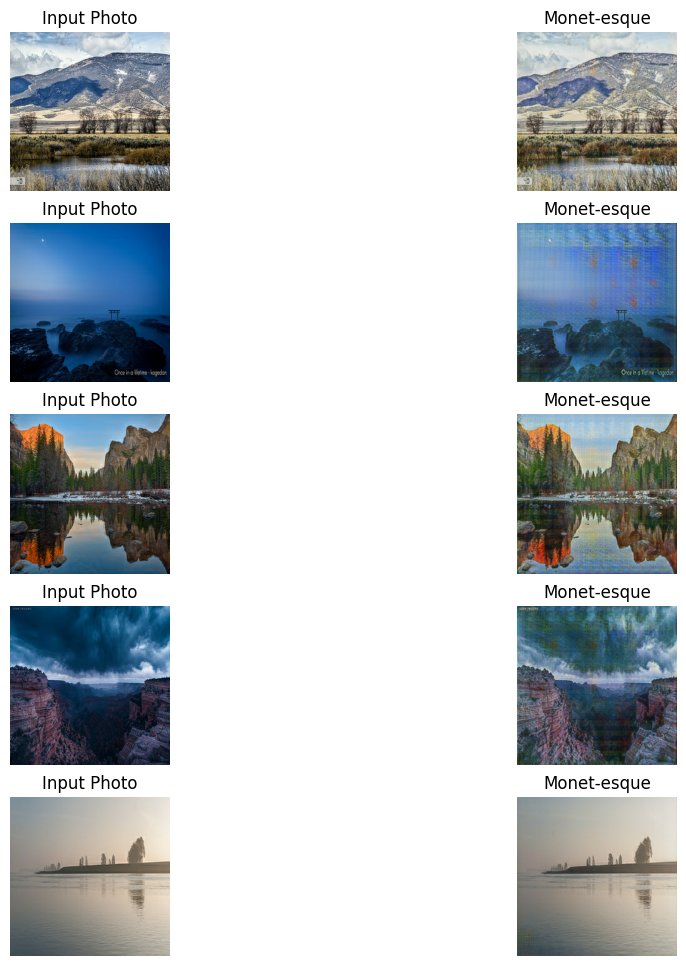

In [4]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

## Conclusion
### The main conclusion that could be gathered from this project is that CycleGAN is an impressive and effective implementation of the GAN model. Due to the nature of our image data being unpaired between target and original images, this architecture was necessary to achieve our translation goals. It more or less achieved this goal in only about 25 epochs, but the results after more extensive training would be interesting to analyze. Additionally, it could be helpful to bring in even more than 300 original Monet painting images to train our data with, and it would be interesting to train a different type of GAN model using paired before-and-after Monet images.

## References
### A large portion of my code is borrowed from Amy Jang's "Monet CycleGAN Tutorial" that can be found here: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook